# EDM Genre Classification - Modeling

#### Import Libraries

In [14]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
sns.set(style='darkgrid')

from sklearn.naive_bayes import GaussianNB, ComplementNB, MultinomialNB, CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_roc_curve, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.impute import KNNImputer
from sklearn import svm
from xgboost import XGBClassifier, XGBRFClassifier
    
import pickle

#### Import Data

In [15]:
# Open pickled raw audio data
with open('checkpoints/pickle_clean_audio_data.pickle', 'rb') as read_file:
    track_data = pickle.load(read_file)

with open('checkpoints/pickle_clean_audio_data_recs.pickle', 'rb') as read_file:
    recs_data = pickle.load(read_file)
    
model_data = track_data.drop(columns='uri')
model_data_recs = recs_data.drop(columns='uri')

In [16]:
model_data.describe()

,duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,...,key_6,key_7,key_8,key_9,key_10,key_11,time_sig_1,time_sig_3,time_sig_4,time_sig_5
count,34398.000000,34398.000000,34398.000000,34398.000000,34398.000000,34398.000000,34398.000000,34398.000000,34398.000000,34398.000000,...,34398.000000,34398.000000,34398.000000,34398.000000,34398.000000,34398.000000,34398.000000,34398.000000,34398.000000,34398.000000
mean,301466.280423,0.045423,0.621237,0.816428,0.443562,0.210067,-6.485391,0.481540,0.087770,139.752092,...,0.086575,0.109658,0.074045,0.086982,0.078813,0.104570,0.001919,0.025031,0.968457,0.004593
std,106829.002949,0.101584,0.145965,0.148511,0.386428,0.179876,3.157602,0.499666,0.081302,18.694061,...,0.281215,0.312467,0.261848,0.281812,0.269450,0.306003,0.043762,0.156220,0.174781,0.067619
min,135000.000000,0.000002,0.153000,0.136000,0.000000,0.007020,-16.829000,0.000000,0.023200,100.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,213432.000000,0.001230,0.514000,0.726000,0.006690,0.090100,-8.656000,0.000000,0.044000,124.033000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,270400.000000,0.007220,0.626000,0.857000,0.460000,0.128000,-6.212000,0.000000,0.057700,136.022500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,384710.000000,0.036400,0.739000,0.937000,0.852000,0.301000,-4.204000,1.000000,0.091100,150.017000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,600000.000000,0.944000,0.988000,1.000000,0.984000,0.985000,2.675000,1.000000,0.898000,199.998000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Train Test Split

Training - 60%, Validation - 20%, Testing - 20%

In [17]:
audio_metrics = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 
                 'loudness', 'speechiness', 'tempo', 'valence']

dummy_vars = ['key_0', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11',
              'time_sig_1', 'time_sig_3', 'time_sig_4', 'time_sig_5', 'mode']

In [18]:
# Train test split
X = model_data[audio_metrics + dummy_vars]
Y = model_data['genre']

X, x_test, Y, y_test = train_test_split(X, Y, test_size=0.20, random_state=13)
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.25, random_state=13)

In [19]:
# Convert loudness data to positive values for certain classification models
x_train2 = x_train.copy()
x_val2 = x_val.copy()
x_test2 = x_test.copy()

x_train2['loudness'] = np.where(x_train2['loudness'] < 0, x_train2['loudness'] * -1, 0)
x_val2['loudness'] = np.where(x_val2['loudness'] < 0, x_val2['loudness'] * -1, 0)
x_test2['loudness'] = np.where(x_test2['loudness'] < 0, x_test2['loudness'] * -1, 0)

## Basic Data Transformations

In [20]:
# Normalized data
mm_scale = MinMaxScaler()
x_train_norm = mm_scale.fit_transform(x_train[audio_metrics])
x_val_norm = mm_scale.fit_transform(x_val[audio_metrics])
x_test_norm = mm_scale.transform(x_test[audio_metrics])

# Add dummies to normalized data
x_train_norm = np.hstack((x_train_norm, x_train[dummy_vars].to_numpy()))
x_val_norm = np.hstack((x_val_norm, x_val[dummy_vars].to_numpy()))
x_test_norm = np.hstack((x_test_norm, x_test[dummy_vars].to_numpy()))

# Standardized data
st_scale = StandardScaler()
x_train_st = st_scale.fit_transform(x_train[audio_metrics])
x_val_st = st_scale.fit_transform(x_val[audio_metrics])
x_test_st = st_scale.transform(x_test[audio_metrics])

# Add dummies to standardized data
x_train_st = np.hstack((x_train_st, x_train[dummy_vars].to_numpy()))
x_val_st = np.hstack((x_val_st, x_val[dummy_vars].to_numpy()))
x_test_st = np.hstack((x_test_st, x_test[dummy_vars].to_numpy()))

# Logistic Regression target columns
unique_vals = model_data['genre'].unique()
lr_y_train = y_train.replace(to_replace=unique_vals, value= list(range(len(unique_vals))))
lr_y_val = y_val.replace(to_replace=unique_vals, value= list(range(len(unique_vals))))
lr_y_test = y_test.replace(to_replace=unique_vals, value= list(range(len(unique_vals))))

## Baseline Models - Simple Validation

In [21]:
rs = 13

#### Logistic Regression

In [22]:
lr_classifier = LogisticRegression(multi_class='multinomial', solver='sag', max_iter=1000, random_state=rs)
lr_classifier.fit(x_train_st, lr_y_train)

y_pred_train = lr_classifier.predict(x_train_st)
y_pred_val = lr_classifier.predict(x_val_st)

lr_train_score = accuracy_score(lr_y_train, y_pred_train, normalize = True)
lr_val_score = accuracy_score(lr_y_val, y_pred_val, normalize = True)

print('Training Score:   ' + str(lr_train_score))
print('Validation Score: ' + str(lr_val_score))

Training Score:   0.6336369803275511
Validation Score: 0.6409883720930233


#### Gaussian Naive Bayes

In [23]:
gnb_classifier = GaussianNB()
gnb_classifier.fit(x_train_st, y_train)

y_pred_train = gnb_classifier.predict(x_train_st)
y_pred_val = gnb_classifier.predict(x_val_st)

gnb_train_score = accuracy_score(y_train, y_pred_train, normalize = True)
gnb_val_score = accuracy_score(y_val, y_pred_val, normalize = True)

print('Training Score:   ' + str(gnb_train_score))
print('Validation Score: ' + str(gnb_val_score))

Training Score:   0.5484543075879446
Validation Score: 0.540406976744186


#### Multinomial Naive Bayes

In [24]:
mnb_classifier = MultinomialNB()
mnb_classifier.fit(x_train2, y_train)

y_pred_train = mnb_classifier.predict(x_train2)
y_pred_val = mnb_classifier.predict(x_val2)

mnb_train_score = accuracy_score(y_train, y_pred_train, normalize = True)
mnb_val_score = accuracy_score(y_val, y_pred_val, normalize = True)

print('Training Score:   ' + str(mnb_train_score))
print('Validation Score: ' + str(mnb_val_score))

Training Score:   0.32764802790968117
Validation Score: 0.3313953488372093


#### Complement Naive Bayes

In [25]:
compnb_classifier = ComplementNB()
compnb_classifier.fit(x_train2, y_train)

y_pred_train = compnb_classifier.predict(x_train2)
y_pred_val = compnb_classifier.predict(x_val2)

compnb_train_score = accuracy_score(y_train, y_pred_train, normalize = True)
compnb_val_score = accuracy_score(y_val, y_pred_val, normalize = True)

print('Training Score:   ' + str(compnb_train_score))
print('Validation Score: ' + str(compnb_val_score))

Training Score:   0.2719255741835449
Validation Score: 0.2686046511627907


#### Categorical Naive Bayes

In [26]:
catnb_classifier = CategoricalNB()
catnb_classifier.fit(x_train2, y_train)

y_pred_train = catnb_classifier.predict(x_train2)
y_pred_val = catnb_classifier.predict(x_val2)

catnb_train_score = accuracy_score(y_train, y_pred_train, normalize = True)
catnb_val_score = accuracy_score(y_val, y_pred_val, normalize = True)

print('Training Score:   ' + str(catnb_train_score))
print('Validation Score: ' + str(catnb_val_score))

Training Score:   0.7791452660141487
Validation Score: 0.6170058139534884


#### K Nearest Neighbors

In [27]:
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(x_train_st, y_train)

y_pred_train = knn_classifier.predict(x_train_st)
y_pred_val = knn_classifier.predict(x_val_st)

knn_train_score = accuracy_score(y_train, y_pred_train, normalize = True)
knn_val_score = accuracy_score(y_val, y_pred_val, normalize = True)

print('Training Score:   ' + str(knn_train_score))
print('Validation Score: ' + str(knn_val_score))

Training Score:   0.7353425719546468
Validation Score: 0.6251453488372093


#### K Nearest Neighbors - Bagged

In [28]:
knn_bag_classifier = BaggingClassifier(KNeighborsClassifier(), random_state=rs)
knn_bag_classifier.fit(x_train, y_train)

y_pred_train = knn_bag_classifier.predict(x_train)
y_pred_val = knn_bag_classifier.predict(x_val)

knn_bag_train_score = accuracy_score(y_train, y_pred_train, normalize = True)
knn_bag_val_score = accuracy_score(y_val, y_pred_val, normalize = True)

print('Training Score:   ' + str(knn_bag_train_score))
print('Validation Score: ' + str(knn_bag_val_score))

Training Score:   0.5853280356623703
Validation Score: 0.35770348837209304


#### Decision Tree

In [29]:
dt_classifier = DecisionTreeClassifier(random_state=rs)
dt_classifier.fit(x_train, y_train)

y_pred_train = dt_classifier.predict(x_train)
y_pred_val = dt_classifier.predict(x_val)

dt_train_score = accuracy_score(y_train, y_pred_train, normalize = True)
dt_val_score = accuracy_score(y_val, y_pred_val, normalize = True)

print('Training Score:   ' + str(dt_train_score))
print('Validation Score: ' + str(dt_val_score))

Training Score:   0.9982556449268339
Validation Score: 0.6540697674418605


#### Decision Tree - Bagged

In [30]:
dt_bag_classifier = BaggingClassifier(DecisionTreeClassifier(), random_state=rs)
dt_bag_classifier.fit(x_train, y_train)

y_pred_train = dt_bag_classifier.predict(x_train)
y_pred_val = dt_bag_classifier.predict(x_val)

dt_bag_train_score = accuracy_score(y_train, y_pred_train, normalize = True)
dt_bag_val_score = accuracy_score(y_val, y_pred_val, normalize = True)

print('Training Score:   ' + str(dt_bag_train_score))
print('Validation Score: ' + str(dt_bag_val_score))

Training Score:   0.985076073262913
Validation Score: 0.7303779069767442


#### Random Forest

In [31]:
rf_classifier = RandomForestClassifier(random_state=rs)
rf_classifier.fit(x_train, y_train)

y_pred_train = rf_classifier.predict(x_train)
y_pred_val = rf_classifier.predict(x_val)

rf_train_score = accuracy_score(y_train, y_pred_train, normalize = True)
rf_val_score = accuracy_score(y_val, y_pred_val, normalize = True)

print('Training Score:   ' + str(rf_train_score))
print('Validation Score: ' + str(rf_val_score))

Training Score:   0.9982556449268339
Validation Score: 0.7563953488372093


#### Random Forest - Bagged

In [32]:
rf_bag_classifier = BaggingClassifier(RandomForestClassifier(), random_state=rs)
rf_bag_classifier.fit(x_train, y_train)

y_pred_train = rf_bag_classifier.predict(x_train)
y_pred_val = rf_bag_classifier.predict(x_val)

rf_bag_train_score = accuracy_score(y_train, y_pred_train, normalize = True)
rf_bag_val_score = accuracy_score(y_val, y_pred_val, normalize = True)

print('Training Score:   ' + str(rf_bag_train_score))
print('Validation Score: ' + str(rf_bag_val_score))

Training Score:   0.9760635720515554
Validation Score: 0.75625


#### Support Vector Machine - SVC

In [33]:
svm_classifier = svm.SVC()
svm_classifier.fit(x_train_st, y_train)

y_pred_train = svm_classifier.predict(x_train_st)
y_pred_val = svm_classifier.predict(x_val_st)

svm_train_score = accuracy_score(y_train, y_pred_train, normalize = True)
svm_val_score = accuracy_score(y_val, y_pred_val, normalize = True)

print('Training Score:   ' + str(svm_train_score))
print('Validation Score: ' + str(svm_val_score))

Training Score:   0.7608295377459056
Validation Score: 0.7261627906976744


#### Support Vector Machine - NuSVC

In [34]:
nusvm_classifier = svm.NuSVC()
nusvm_classifier.fit(x_train_st, y_train)

y_pred_train = nusvm_classifier.predict(x_train_st)
y_pred_val = nusvm_classifier.predict(x_val_st)

nusvm_train_score = accuracy_score(y_train, y_pred_train, normalize = True)
nusvm_val_score = accuracy_score(y_val, y_pred_val, normalize = True)

print('Training Score:   ' + str(nusvm_train_score))
print('Validation Score: ' + str(nusvm_val_score))

Training Score:   0.6874212617501696
Validation Score: 0.6859011627906977


#### Support Vector Machine - LinearSVC

In [35]:
linsvm_classifier = svm.LinearSVC(max_iter=50000)
linsvm_classifier.fit(x_train_st, y_train)

y_pred_train = linsvm_classifier.predict(x_train_st)
y_pred_val = linsvm_classifier.predict(x_val_st)

linsvm_train_score = accuracy_score(y_train, y_pred_train, normalize = True)
linsvm_val_score = accuracy_score(y_val, y_pred_val, normalize = True)

print('Training Score:   ' + str(linsvm_train_score))
print('Validation Score: ' + str(linsvm_val_score))

Training Score:   0.5909971896501599
Validation Score: 0.6


#### XGBoost Classifier

In [36]:
xgb_classifier = XGBClassifier()
xgb_classifier.fit(x_train, y_train)

y_pred_train = xgb_classifier.predict(x_train)
y_pred_val = xgb_classifier.predict(x_val)

xgb_train_score = accuracy_score(y_train, y_pred_train, normalize = True)
xgb_val_score = accuracy_score(y_val, y_pred_val, normalize = True)

print('Training Score:   ' + str(xgb_train_score))
print('Validation Score: ' + str(xgb_val_score))

[09:49:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/davidwismer/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Training Score:   0.9585715670123074
Validation Score: 0.7638081395348837


#### XGBoost Random Forest Classifier

In [37]:
xgbrf_classifier = XGBRFClassifier()
xgbrf_classifier.fit(x_train, y_train)

y_pred_train = xgbrf_classifier.predict(x_train)
y_pred_val = xgbrf_classifier.predict(x_val)

xgbrf_train_score = accuracy_score(y_train, y_pred_train, normalize = True)
xgbrf_val_score = accuracy_score(y_val, y_pred_val, normalize = True)

print('Training Score:   ' + str(xgbrf_train_score))
print('Validation Score: ' + str(xgbrf_val_score))

[09:49:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Score:   0.7591820912879155
Validation Score: 0.7287790697674419


#### Baseline Model Comparison

In [39]:
models = ['Logistic Regression',
          'Gaussian Naive Bayes',
          'Multinomial Naive Bayes',
          'Complement Naive Bayes',
          'Categorical Naive Bayes',
          'K Nearest Neighbors',
          'Decision Tree',
          'Random Forest',
          'Support Vector Classifier',
          'Nu-Support Vector Classifier',
          'Linear Support Vector Classifier',
          'XGBoost Classifier',
          'XGBoost Random Forest Classifier']

train_scores = np.array([lr_train_score,
                         gnb_train_score,
                         mnb_train_score,
                         compnb_train_score,
                         catnb_train_score,
                         knn_train_score,
                         dt_train_score,
                         rf_train_score,
                         svm_train_score,
                         nusvm_train_score,
                         linsvm_train_score,
                         xgb_train_score,
                         xgbrf_train_score])

val_scores = np.array([lr_val_score,
                       gnb_val_score,
                       mnb_val_score,
                       compnb_val_score,
                       catnb_val_score,
                       knn_val_score,
                       dt_val_score,
                       rf_val_score,
                       svm_val_score,
                       nusvm_val_score,
                       linsvm_val_score,
                       xgb_val_score,
                       xgbrf_val_score])

gen_error = train_scores - val_scores

baseline_dict = {'Model' : models, 'Train Score' : train_scores, 'Validation Score' : val_scores, 'Generalization Error' : gen_error}

In [77]:
cm = sns.light_palette("green", as_cmap=True)
baseline_summary = pd.DataFrame(baseline_dict)
baseline_summary.style.background_gradient(cmap=cm)

,Model,Train Score,Validation Score,Generalization Error
0,Logistic Regression,0.633637,0.640988,-0.007351
1,Gaussian Naive Bayes,0.548454,0.540407,0.008047
2,Multinomial Naive Bayes,0.327648,0.331395,-0.003747
3,Complement Naive Bayes,0.271926,0.268605,0.003321
4,Categorical Naive Bayes,0.779145,0.617006,0.162139
5,K Nearest Neighbors,0.735343,0.625145,0.110197
6,Decision Tree,0.998256,0.654070,0.344186
7,Random Forest,0.998256,0.756395,0.241860
8,Support Vector Classifier,0.760830,0.726163,0.034667
9,Nu-Support Vector Classifier,0.687421,0.685901,0.001520


## Hyperparameter Tuning and Cross Validation for Top Baseline Models

- Random Forest Classifier
- Support Vector Classifier
- Logistic Regression

#### Cross Validation Train Test Split


In [41]:
# Train test split
X = model_data[audio_metrics + dummy_vars]
Y = model_data['genre']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=rs)

In [42]:
# Normalized data
mm_scale = MinMaxScaler()
x_train_norm = mm_scale.fit_transform(x_train[audio_metrics])
x_test_norm = mm_scale.transform(x_test[audio_metrics])

# Add dummies to normalized data
x_train_norm = np.hstack((x_train_norm, x_train[dummy_vars].to_numpy()))
x_test_norm = np.hstack((x_test_norm, x_test[dummy_vars].to_numpy()))

# Standardized data
st_scale = StandardScaler()
x_train_st = st_scale.fit_transform(x_train[audio_metrics])
x_test_st = st_scale.transform(x_test[audio_metrics])

# Add dummies to standardized data
x_train_st = np.hstack((x_train_st, x_train[dummy_vars].to_numpy()))
x_test_st = np.hstack((x_test_st, x_test[dummy_vars].to_numpy()))

# Logistic Regression target columns
unique_vals = model_data['genre'].unique()
lr_y_train = y_train.replace(to_replace=unique_vals, value= list(range(len(unique_vals))))
lr_y_test = y_test.replace(to_replace=unique_vals, value= list(range(len(unique_vals))))

#### XGBoost Classifier

In [45]:
# Hyperparameter CV Test - Round 1
parameters = {'learning_rate' : [0.01, 0.05, 0.1],
              'n_estimators' : [100],
              'max_depth' : [5, 10, 15],
              'subsample' : [0.8, 1],
              'colsample_bytree' : [0.25, 0.75],
              'gamma' : [0, 1, 5]
             }

# clf = ensemble.RandomForestRegressor(n_estimators=500, n_jobs=1, verbose=1)
xgb_grid = GridSearchCV(XGBClassifier(random_state=rs), param_grid=parameters, cv=5, n_jobs=-1, verbose=1)
xgb_grid.fit(x_train, y_train)
print(xgb_grid.best_estimator_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 51.0min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 72.5min finished
/Users/davidwismer/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:31:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.75, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1,
              objective='multi:softprob', random_state=13, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [47]:
pd.DataFrame(xgb_grid.cv_results_).drop(columns='params').sort_values('rank_test_score')[0:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
82,281.972918,0.450273,0.068374,0.003282,0.75,1,0.05,15,100,0.8,0.767624,0.769622,0.764172,0.774123,0.770125,0.769133,0.003256,1
68,153.294617,0.387013,0.050577,0.004475,0.75,0,0.1,10,100,0.8,0.773438,0.765988,0.761991,0.773396,0.770671,0.769097,0.004471,2
87,162.759562,0.443875,0.047843,0.001305,0.75,1,0.1,10,100,1,0.771621,0.764898,0.765080,0.775032,0.767218,0.768770,0.003959,3
80,166.781102,0.266503,0.053892,0.002323,0.75,1,0.05,10,100,0.8,0.769440,0.769077,0.762173,0.773578,0.768126,0.768479,0.003665,4
88,270.245414,0.914239,0.061137,0.006146,0.75,1,0.1,15,100,0.8,0.767442,0.767442,0.760901,0.775577,0.769217,0.768116,0.004687,5


In [48]:
# Hyperparameter CV Test - Round 2
parameters = {'learning_rate' : [0.05, 0.075, 0.1],
              'n_estimators' : [100],
              'max_depth' : [15, 30],
              'subsample' : [0.8],
              'colsample_bytree' : [0.75],
              'gamma' : [1]
             }

# clf = ensemble.RandomForestRegressor(n_estimators=500, n_jobs=1, verbose=1)
xgb_grid = GridSearchCV(XGBClassifier(random_state=rs), param_grid=parameters, cv=5, n_jobs=-1, verbose=1)
xgb_grid.fit(x_train, y_train)
print(xgb_grid.best_estimator_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  9.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  9.7min finished
/Users/davidwismer/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:54:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.75, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1,
              objective='multi:softprob', random_state=13, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [50]:
pd.DataFrame(xgb_grid.cv_results_).drop(columns='params').sort_values('rank_test_score')[0:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,239.974297,0.489229,0.085780,0.003861,0.75,1,0.05,15,100,0.8,0.767624,0.769622,0.764172,0.774123,0.770125,0.769133,0.003256,1
1,365.301093,0.712210,0.086653,0.002934,0.75,1,0.05,30,100,0.8,0.769622,0.769622,0.760719,0.772851,0.769035,0.768370,0.004054,2
2,230.828138,0.610826,0.063906,0.001805,0.75,1,0.075,15,100,0.8,0.770531,0.766533,0.761810,0.770852,0.771397,0.768225,0.003641,3
4,224.880588,0.877405,0.054290,0.006607,0.75,1,0.1,15,100,0.8,0.767442,0.767442,0.760901,0.775577,0.769217,0.768116,0.004687,4
5,232.744590,37.078811,0.042923,0.008899,0.75,1,0.1,30,100,0.8,0.764898,0.765262,0.761628,0.774850,0.766128,0.766553,0.004420,5


In [51]:
# Hyperparameter CV Test - Round 3
parameters = {'learning_rate' : [0.05, 0.06],
              'n_estimators' : [100, 200],
              'max_depth' : [15, 30],
              'subsample' : [0.8],
              'colsample_bytree' : [0.75],
              'gamma' : [1]
             }

# clf = ensemble.RandomForestRegressor(n_estimators=500, n_jobs=1, verbose=1)
xgb_grid = GridSearchCV(XGBClassifier(random_state=rs), param_grid=parameters, cv=5, n_jobs=-1, verbose=1)
xgb_grid.fit(x_train, y_train)
print(xgb_grid.best_estimator_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 18.6min finished
/Users/davidwismer/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:16:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.75, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.06, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=16, num_parallel_tree=1,
              objective='multi:softprob', random_state=13, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [52]:
pd.DataFrame(xgb_grid.cv_results_).drop(columns='params').sort_values('rank_test_score')[0:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,445.158271,1.952289,0.095777,0.005684,0.75,1,0.06,15,200,0.8,0.770531,0.768714,0.764172,0.775395,0.770671,0.769896,0.003617,1
1,442.885345,0.890761,0.115489,0.015984,0.75,1,0.05,15,200,0.8,0.767987,0.767260,0.764898,0.773941,0.773033,0.769424,0.003483,2
0,227.136528,0.498428,0.063576,0.003291,0.75,1,0.05,15,100,0.8,0.767624,0.769622,0.764172,0.774123,0.770125,0.769133,0.003256,3
3,726.527752,1.525195,0.122087,0.016311,0.75,1,0.05,30,200,0.8,0.769985,0.767442,0.763990,0.773396,0.770852,0.769133,0.003199,3
7,348.198002,71.161988,0.067858,0.016337,0.75,1,0.06,30,200,0.8,0.766715,0.768532,0.761446,0.774668,0.773215,0.768915,0.004740,5


In [53]:
# Hyperparameter CV Test - Round 4
parameters = {'learning_rate' : [0.06],
              'n_estimators' : [200, 500, 1000],
              'max_depth' : [15],
              'subsample' : [0.8],
              'colsample_bytree' : [0.75],
              'gamma' : [1]
             }

# clf = ensemble.RandomForestRegressor(n_estimators=500, n_jobs=1, verbose=1)
xgb_grid = GridSearchCV(XGBClassifier(random_state=rs), param_grid=parameters, cv=5, n_jobs=-1, verbose=1)
xgb_grid.fit(x_train, y_train)
print(xgb_grid.best_estimator_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 20.6min finished
/Users/davidwismer/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:39:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.75, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.06, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=16, num_parallel_tree=1,
              objective='multi:softprob', random_state=13, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [54]:
pd.DataFrame(xgb_grid.cv_results_).drop(columns='params').sort_values('rank_test_score')[0:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,876.980160,1.086795,0.215075,0.050775,0.75,1,0.06,15,500,0.8,0.770894,0.767987,0.765262,0.774850,0.771761,0.770151,0.003281,1
2,1233.242498,0.715664,0.252185,0.070744,0.75,1,0.06,15,1000,0.8,0.769804,0.768532,0.767078,0.773941,0.771034,0.770078,0.002337,2
0,447.645209,1.115750,0.093598,0.007027,0.75,1,0.06,15,200,0.8,0.770531,0.768714,0.764172,0.775395,0.770671,0.769896,0.003617,3


In [ ]:
# Best XGBoost Classifier Perforer
parameters = {'learning_rate' : [0.06],
              'n_estimators' : [500], 
              'max_depth' : [15], 
              'subsample' : [0.8],
              'colsample_bytree' : [0.75],
              'gamma' : [1]
             }

#### Random Forest

In [760]:
# Hyperparameter CV Test - Round 1
parameters = {'bootstrap' : [True],
              'max_features' : ['auto'],
              'n_estimators' : [100, 300, 500], 
              'max_depth' : [None, 5, 15, 30], 
              'min_samples_leaf' : [1, 5, 10],
              'min_samples_split' : [2, 5, 10]
             }

rf_grid = GridSearchCV(RandomForestClassifier(random_state=rs), param_grid=parameters, cv=5, n_jobs=-1, verbose=1)
rf_grid.fit(x_train, y_train)
print(rf_grid.best_estimator_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 10.0min finished


RandomForestClassifier(n_estimators=500, random_state=13)


In [761]:
pd.DataFrame(rf_grid.cv_results_).drop(columns='params').sort_values('rank_test_score')[0:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,35.305544,0.061595,1.075322,0.008034,True,None,auto,1,2,500,0.763990,0.756904,0.753452,0.762675,0.757223,0.758849,0.003915,1
83,41.133115,0.053456,1.136577,0.018382,True,30,auto,1,2,500,0.764898,0.757631,0.752907,0.761221,0.756860,0.758703,0.004071,2
86,39.295221,0.082322,1.050073,0.010520,True,30,auto,1,5,500,0.763445,0.756904,0.752907,0.761766,0.757223,0.758449,0.003757,3
5,35.764841,0.240512,1.093637,0.057424,True,None,auto,1,5,500,0.762536,0.755451,0.752180,0.761948,0.757768,0.757977,0.003914,4
4,20.843695,0.247816,0.592446,0.011002,True,None,auto,1,5,300,0.762536,0.757812,0.750908,0.761403,0.757223,0.757977,0.004076,5


In [762]:
# Hyperparameter CV Test - Round 2
parameters = {'bootstrap' : [True],
              'max_features' : ['auto'],
              'n_estimators' : [500, 750, 1000], 
              'max_depth' : [None, 30, 50], 
              'min_samples_split' : [2, 3, 4, 5]
             }

rf_grid = GridSearchCV(RandomForestClassifier(random_state=rs), param_grid=parameters, cv=5, n_jobs=-1, verbose=1)
rf_grid.fit(x_train, y_train)
print(rf_grid.best_estimator_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 11.8min finished


RandomForestClassifier(max_depth=30, n_estimators=1000, random_state=13)


In [763]:
pd.DataFrame(rf_grid.cv_results_).drop(columns='params').sort_values('rank_test_score')[0:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
14,82.091154,0.245004,3.497163,0.197214,True,30,auto,2,1000,0.764535,0.758176,0.753815,0.763220,0.758677,0.759685,0.003841,1
29,80.407710,0.262278,2.235989,0.063695,True,50,auto,3,1000,0.766170,0.757086,0.754360,0.762857,0.757587,0.759612,0.004280,2
5,81.331302,0.452900,2.271380,0.111170,True,None,auto,3,1000,0.766170,0.757086,0.754360,0.762857,0.757587,0.759612,0.004280,2
13,61.336194,0.129474,2.417812,0.333904,True,30,auto,2,750,0.763626,0.758176,0.755451,0.762130,0.758314,0.759539,0.002949,4
1,55.635553,0.071098,4.948134,0.361561,True,None,auto,2,750,0.762355,0.757267,0.754360,0.762493,0.760494,0.759394,0.003145,5


In [764]:
# Hyperparameter CV Test - Round 3
parameters = {'bootstrap' : [True],
              'max_features' : ['auto'],
              'n_estimators' : [1000, 2000, 3000], 
              'max_depth' : [30, 50, 70], 
              'min_samples_leaf' : [1, 5],
              'min_samples_split' : [2, 3]
             }

rf_grid = GridSearchCV(RandomForestClassifier(random_state=rs), param_grid=parameters, cv=5, n_jobs=-1, verbose=1)
rf_grid.fit(x_train, y_train)
print(rf_grid.best_estimator_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 30.6min finished


RandomForestClassifier(max_depth=30, n_estimators=3000, random_state=13)


In [765]:
pd.DataFrame(rf_grid.cv_results_).drop(columns='params').sort_values('rank_test_score')[0:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,245.854928,0.354332,23.677651,0.411336,True,30,auto,1,2,3000,0.765080,0.758721,0.755087,0.762675,0.758495,0.760012,0.003493,1
0,75.110345,0.261229,5.473007,0.206539,True,30,auto,1,2,1000,0.764535,0.758176,0.753815,0.763220,0.758677,0.759685,0.003841,2
26,254.205860,0.750165,19.343383,1.252700,True,70,auto,1,2,3000,0.764717,0.758358,0.753634,0.762857,0.758677,0.759648,0.003867,3
14,253.904983,0.740412,21.161616,1.920730,True,50,auto,1,2,3000,0.764717,0.758358,0.753634,0.762857,0.758677,0.759648,0.003867,3
27,84.069335,0.264914,4.618063,0.519080,True,70,auto,1,3,1000,0.766170,0.757086,0.754360,0.762857,0.757587,0.759612,0.004280,5


In [766]:
# Hyperparameter CV Test - Round 4
parameters = {'bootstrap' : [True],
              'max_features' : ['auto'],
              'n_estimators' : [3000, 5000], 
              'max_depth' : [20, 25, 30, 35, 40], 
              'min_samples_leaf' : [1],
              'min_samples_split' : [2]
             }

rf_grid = GridSearchCV(RandomForestClassifier(random_state=rs), param_grid=parameters, cv=5, n_jobs=-1, verbose=1)
rf_grid.fit(x_train, y_train)
print(rf_grid.best_estimator_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 20.8min finished


RandomForestClassifier(max_depth=30, n_estimators=3000, random_state=13)


In [ ]:
# Hyperparameter CV Test - Round 5
parameters = {'bootstrap' : [True],
              'max_features' : ['auto'],
              'n_estimators' : [3000, 5000], 
              'max_depth' : [20, 30, 40], 
              'min_samples_leaf' : [1, 3, 5],
              'min_samples_split' : [2, 5, 10]
             }

rf_grid = GridSearchCV(RandomForestClassifier(random_state=rs), param_grid=parameters, cv=5, n_jobs=-1, verbose=2)
rf_grid.fit(x_train, y_train)
print(rf_grid.best_estimator_)

In [777]:
# Hyperparameter CV Test - Round 6
parameters = {'bootstrap' : [True],
              'max_features' : ['auto'],
              'n_estimators' : [5000], 
              'max_depth' : [20, 30, 40], 
              'min_samples_leaf' : [1],
              'min_samples_split' : [2, 5]
             }

rf_grid = GridSearchCV(RandomForestClassifier(random_state=rs), param_grid=parameters, cv=5, n_jobs=-1, verbose=1)
rf_grid.fit(x_train, y_train)
print(rf_grid.best_estimator_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 14.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 14.9min finished


RandomForestClassifier(max_depth=40, n_estimators=5000, random_state=13)


In [779]:
# Hyperparameter CV Test - Round 7
parameters = {'bootstrap' : [True],
              'max_features' : ['auto'],
              'n_estimators' : [3000], 
              'max_depth' : [20, 30, 40], 
              'min_samples_leaf' : [1],
              'min_samples_split' : [2]
             }

rf_grid = GridSearchCV(RandomForestClassifier(random_state=rs), param_grid=parameters, cv=5, n_jobs=-1, verbose=1)
rf_grid.fit(x_train, y_train)
print(rf_grid.best_estimator_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  4.1min finished


RandomForestClassifier(max_depth=30, n_estimators=3000, random_state=13)


In [780]:
pd.DataFrame(rf_grid.cv_results_).drop(columns='params').sort_values('rank_test_score')[0:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,213.914520,0.244483,28.988567,0.227665,True,30,auto,1,2,3000,0.765080,0.758721,0.755087,0.762675,0.758495,0.760012,0.003493,1
0,209.404680,0.215100,32.863391,0.139943,True,20,auto,1,2,3000,0.765262,0.757994,0.755087,0.761766,0.759404,0.759903,0.003443,2
2,213.892563,0.163606,29.006618,0.130167,True,40,auto,1,2,3000,0.764898,0.758358,0.753634,0.762857,0.758677,0.759685,0.003915,3


In [781]:
# Hyperparameter CV Test - Round 8
parameters = {'bootstrap' : [True],
              'max_features' : ['auto'],
              'n_estimators' : [100, 300, 500, 750, 1000], 
              'max_depth' : [30], 
              'min_samples_leaf' : [1],
              'min_samples_split' : [2]
             }

rf_grid = GridSearchCV(RandomForestClassifier(random_state=rs), param_grid=parameters, cv=5, n_jobs=-1, verbose=1)
rf_grid.fit(x_train, y_train)
print(rf_grid.best_estimator_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:   56.1s remaining:   14.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.2min finished


RandomForestClassifier(max_depth=30, n_estimators=1000, random_state=13)


In [782]:
pd.DataFrame(rf_grid.cv_results_).drop(columns='params').sort_values('rank_test_score')[0:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,49.278001,2.383262,1.206285,0.023854,True,30,auto,1,2,1000,0.764535,0.758176,0.753815,0.763220,0.758677,0.759685,0.003841,1
3,45.244822,0.795852,1.057005,0.037604,True,30,auto,1,2,750,0.763626,0.758176,0.755451,0.762130,0.758314,0.759539,0.002949,2
2,33.887882,0.077542,1.039588,0.008045,True,30,auto,1,2,500,0.764898,0.757631,0.752907,0.761221,0.756860,0.758703,0.004071,3
1,20.390475,0.039422,0.639030,0.013029,True,30,auto,1,2,300,0.763263,0.757631,0.752725,0.760494,0.754316,0.757686,0.003872,4
0,6.586421,0.031684,0.220395,0.013265,True,30,auto,1,2,100,0.759448,0.753089,0.750727,0.756315,0.755043,0.754924,0.002946,5


In [828]:
# Best Random Forest performer
parameters = {'bootstrap' : [True],
              'max_features' : ['auto'],
              'n_estimators' : [3000], 
              'max_depth' : [30], 
              'min_samples_leaf' : [1],
              'min_samples_split' : [2]
             }

#### Random Forest - Recommendation Data

In [830]:
X = model_data_recs[audio_metrics + dummy_vars]
Y = model_data_recs['genre']

X, x_test, Y, y_test = train_test_split(X, Y, test_size=0.20, random_state=13)
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.25, random_state=13)

In [831]:
# clf = ensemble.RandomForestRegressor(n_estimators=500, n_jobs=1, verbose=1)
rf_grid = GridSearchCV(RandomForestClassifier(random_state=rs), param_grid=parameters, cv=5, n_jobs=-1, verbose=1)
rf_grid.fit(x_train, y_train)
print(rf_grid.best_estimator_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.6s finished


RandomForestClassifier(max_depth=30, n_estimators=3000, random_state=13)


In [832]:
pd.DataFrame(rf_grid.cv_results_).drop(columns='params').sort_values('rank_test_score')[0:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,9.21856,0.058484,0.393435,0.00565,True,30,auto,1,2,3000,0.761905,0.740476,0.771429,0.780952,0.807143,0.772381,0.021956,1


#### Support Vector Machine

In [788]:
parameters = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
  
svm_grid = GridSearchCV(svm.SVC(random_state=rs), param_grid=parameters, verbose = 1)
svm_grid.fit(x_train_st, y_train)
print(svm_grid.best_estimator_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 57.5min finished


SVC(C=1, gamma=0.1)


In [789]:
pd.DataFrame(svm_grid.cv_results_).drop(columns='params').sort_values('rank_test_score')[0:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,9.914833,0.081023,2.680622,0.030333,1,0.1,rbf,0.738735,0.726199,0.722202,0.731601,0.726513,0.729050,0.005688,1
11,13.422931,0.201334,2.850712,0.058100,10,0.1,rbf,0.737645,0.728198,0.716388,0.724332,0.729602,0.727233,0.006942,2
22,51.174569,2.492654,2.551774,0.014567,1000,0.01,rbf,0.736010,0.722747,0.716388,0.731964,0.724696,0.726361,0.006925,3
17,15.774720,0.532427,2.638611,0.091345,100,0.01,rbf,0.734375,0.722929,0.719113,0.730147,0.723242,0.725961,0.005510,4
23,19.049012,0.515522,2.804666,0.071140,1000,0.001,rbf,0.723656,0.710574,0.714753,0.722878,0.717245,0.717821,0.004937,5


In [ ]:
# Best SVM performer
parameters = {'C': [1], 
              'gamma': [0.1],
              'kernel': ['rbf']} 

#### Logistic Regression

In [88]:
parameters = {'C': [0.1, 1, 10, 100, 1000], 
              'penalty': ['l2']} 
  
lr_grid = GridSearchCV(LogisticRegression(multi_class='multinomial', solver='sag', max_iter=1000, random_state=rs), param_grid=parameters, verbose = 1)
lr_grid.fit(x_train_st, y_train)
print(lr_grid.best_estimator_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  1.2min finished


LogisticRegression(C=100, max_iter=1000, multi_class='multinomial',
                   random_state=13, solver='sag')


In [89]:
pd.DataFrame(lr_grid.cv_results_).drop(columns='params').sort_values('rank_test_score')[0:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,1.492408,0.275671,0.004171,0.000019,100,l2,0.640625,0.632631,0.627725,0.641105,0.634381,0.635293,0.005048,1
4,1.624621,0.240090,0.004728,0.001033,1000,l2,0.640625,0.632631,0.627725,0.641105,0.634381,0.635293,0.005048,1
2,8.615861,0.902749,0.004263,0.000140,10,l2,0.640443,0.632449,0.627725,0.641105,0.634200,0.635184,0.005036,3
1,2.642342,0.069107,0.004245,0.000081,1,l2,0.640262,0.631904,0.627180,0.641468,0.634200,0.635003,0.005308,4
0,0.498998,0.029767,0.004327,0.000123,0.1,l2,0.639898,0.630996,0.625363,0.639833,0.632746,0.633767,0.005545,5


## Model Selection - Cross Validation

***Random Forest Classifier*** and ***XGBoost Classifier*** were the best performing classification models in both simple validation and cross validation with hyperparameter tuning. XGBoost slightly beat out Random Forest. 

The optimal XBoost parameters were as follows:

- **learning_rate**. 0.06
- **n_estimators** - 500
- **max_depth** - 15
- **subsample** - 0.8
- **colsample_bytree** - 0.75
- **gamma** - 1.0

The optimal Random Forest parameters were as follows:

- **n_estimators** - The optimal number of trees for optimal performance is ***more trees***. But from 1,000 to 3,000 trees, the mean R-Squared increase was around 0.002. As such, I'll move forward with 1,000 estimators.
- **max_depth** - 30
- **min_samples_leaf** - 1 (default)
- **mix_samples_split** - 2 (default)
- **max_features** - auto (default)
- **max_features** - True (default)
- **bootstrap** - True (default)



## Imputing Tempo Values - Random Forest

In [669]:
tempo_dict = {'dnb' : [160, 180],
              'deep_house' : [115, 130],
              'dubstep' : [130, 145],
              'hardstyle' : [145, 155],
              'prog_house' : [115, 130],
              'techno' : [120, 160],
              'trance' : [120, 135]
             }

In [670]:
def impute_tempo_by_genre(df, genre=None, range_method='set'):
    """
    Return df for a specified genre with NaN imputed with a tempo value.
    """
    if genre:
        df = df[df['genre'] == genre]
        if range_method == 'set':
            high = 180
            low = 115
        else:
            high = tempo_dict[genre][1] + ((tempo_dict[genre][1] - tempo_dict[genre][0]) * 0.2) 
            low = tempo_dict[genre][0] - ((tempo_dict[genre][1] - tempo_dict[genre][0]) * 0.2)
    else:
        high = 180
        low = 115
    
    tempo = df['tempo']
    df.drop(labels=['tempo'], axis=1,inplace = True)
    df.insert(0, 'tempo', tempo)
    
    imputer = KNNImputer(n_neighbors=2000, weights='uniform', metric='nan_euclidean')
    
    X = df.drop(columns='genre')
    X['tempo'] = np.where(((X['tempo'] > high) | (X['tempo'] < low)), np.nan, X['tempo'])
    
    imputer.fit(X)
    
    X_imputed = imputer.transform(X)
    
    df['tempo'] = X_imputed[:,0]
    
    return df

#### Impute Using Genre Tempo Dictionary

In this attempt, I imputed all training data tempo values outside of the prescribed subgenre tempos as outlined in the EDA notebook. In the training data, I imputed on a subgenre basis using KNN imputation. For validation data, I imputed using KNN imputation, but since no subgenre information is known, I used the entire population for finding nearest neighbors.

In [799]:
X = model_data[audio_metrics + dummy_vars]
Y = model_data['genre']

In [800]:
X, x_test, Y, y_test = train_test_split(X, Y, test_size=0.20, random_state=13)
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.25, random_state=13)

In [801]:
# Create complete training and validation sets
train_data = x_train.copy()
train_data['genre'] = y_train

val_data = x_val.copy()
val_data['genre'] = y_val

In [ ]:
# Impute tempo by genre in training data
dnb_train_imputed = impute_tempo_by_genre(train_data, 'dnb', 'set')
deep_house_train_imputed = impute_tempo_by_genre(train_data, 'deep_house', 'set')
dubstep_train_imputed = impute_tempo_by_genre(train_data, 'dubstep', 'set')
hardstyle_train_imputed = impute_tempo_by_genre(train_data, 'hardstyle', 'set')
prog_house_train_imputed = impute_tempo_by_genre(train_data, 'prog_house', 'set')
techno_train_imputed = impute_tempo_by_genre(train_data, 'techno', 'set')
trance_train_imputed = impute_tempo_by_genre(train_data, 'trance', 'set')

In [803]:
# Concatenate imputed training datasets by genre
all_genres_train_imputed = pd.concat([dnb_train_imputed,
                                      deep_house_train_imputed,
                                      dubstep_train_imputed,
                                      hardstyle_train_imputed,
                                      prog_house_train_imputed,
                                      techno_train_imputed,
                                      trance_train_imputed])

In [804]:
# Convert tempo to NaN where outside of the accepted range
val_data['tempo'] = np.where(((val_data['tempo'] > 180) | (val_data['tempo'] < 115)), np.nan, val_data['tempo'])

# Add NaN tempo rows for validation data to the imputed training data
val_na = val_data[val_data['tempo'].isna()]
val_na_length = len(val_na)

train_and_val_nan = pd.concat([all_genres_train_imputed,
                               val_na])

In [805]:
# Impute the tempo for the validation data using the training data
val_imputed = impute_tempo_by_genre(train_and_val_nan)
val_imputed = val_imputed[-1 * val_na_length:]

In [806]:
# Replace NaN rows with new imputed tempo rows in the validation set
val_data.dropna(inplace=True)
val_data = pd.concat([val_data, val_imputed])

In [807]:
x_train = all_genres_train_imputed.drop(columns='genre')
y_train = all_genres_train_imputed['genre']
x_val = val_data.drop(columns='genre')
y_val = val_data['genre']

In [808]:
rf_classifier = RandomForestClassifier(n_estimators=1000,
                                       max_depth=30,
                                       oob_score=True, 
                                       criterion='gini', 
                                       random_state=13)

rf_classifier.fit(x_train, y_train)
y_pred_train = rf_classifier.predict(x_train)
y_pred_val = rf_classifier.predict(x_val)
train_score = accuracy_score(y_train, y_pred_train, normalize = True)
val_score = accuracy_score(y_val, y_pred_val, normalize = True)

In [809]:
print('Training Score:   ' + str(train_score))
print('Validation Score: ' + str(val_score))

Training Score:   0.998304099234422
Validation Score: 0.1375


#### Impute Only Tempo Outside 115-180 BPM

In this attempt, I imputed all tempo values outside 115-180 BPM. In the training data, I imputed on a subgenre basis using KNN imputation. For validation data, I imputed using KNN imputation, but since no subgenre information is known, I used the entire population for finding nearest neighbors.

In [810]:
X = model_data[audio_metrics]
Y = model_data['genre']

In [811]:
X, x_test, Y, y_test = train_test_split(X, Y, test_size=0.20, random_state=13)
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.25, random_state=13)

In [812]:
# Create complete training and validation sets
train_data = x_train.copy()
train_data['genre'] = y_train

val_data = x_val.copy()
val_data['genre'] = y_val

In [ ]:
# Impute tempo by genre in training data
dnb_train_imputed = impute_tempo_by_genre(train_data, 'dnb')
deep_house_train_imputed = impute_tempo_by_genre(train_data, 'deep_house')
dubstep_train_imputed = impute_tempo_by_genre(train_data, 'dubstep')
hardstyle_train_imputed = impute_tempo_by_genre(train_data, 'hardstyle')
prog_house_train_imputed = impute_tempo_by_genre(train_data, 'prog_house')
techno_train_imputed = impute_tempo_by_genre(train_data, 'techno')
trance_train_imputed = impute_tempo_by_genre(train_data, 'trance')

In [814]:
# Concatenate imputed training datasets by genre
all_genres_train_imputed = pd.concat([dnb_train_imputed,
                                      deep_house_train_imputed,
                                      dubstep_train_imputed,
                                      hardstyle_train_imputed,
                                      prog_house_train_imputed,
                                      techno_train_imputed,
                                      trance_train_imputed])

In [815]:
# Convert tempo to NaN where outside of the accepted range
val_data['tempo'] = np.where(((val_data['tempo'] > 180) | (val_data['tempo'] < 115)), np.nan, val_data['tempo'])

# Add NaN tempo rows for validation data to the imputed training data
val_na = val_data[val_data['tempo'].isna()]
val_na_length = len(val_na)

train_and_val_nan = pd.concat([all_genres_train_imputed,
                               val_na])

In [816]:
# Impute the tempo for the validation data using the training data
val_imputed = impute_tempo_by_genre(train_and_val_nan)
val_imputed = val_imputed[-1 * val_na_length:]

In [817]:
# Replace NaN rows with new imputed tempo rows in the validation set
val_data.dropna(inplace=True)
val_data = pd.concat([val_data, val_imputed])

In [818]:
x_train = all_genres_train_imputed.drop(columns='genre')
y_train = all_genres_train_imputed['genre']
x_val = val_data.drop(columns='genre')
y_val = val_data['genre']

In [819]:
rf_classifier.fit(x_train, y_train)
y_pred_train = rf_classifier.predict(x_train)
y_pred_val = rf_classifier.predict(x_val)
train_score = accuracy_score(y_train, y_pred_train, normalize = True)
val_score = accuracy_score(y_val, y_pred_val, normalize = True)

In [820]:
print('Training Score:   ' + str(train_score))
print('Validation Score: ' + str(val_score))

Training Score:   0.998304099234422
Validation Score: 0.13924418604651162


#### Impute Using Genre Dictionary -  Training and Validation Data

This is not a valid approach because subgenre for validation data should not be known. But given that the results from the valid imputation approaches was ineffective, I wanted to see if imputation on the entire dataset would even provide improved performance.

In [ ]:
# Impute tempo by genre in all model data (training and testing)
dnb_imputed = impute_tempo_by_genre(model_data, 'dnb')
deep_house_imputed = impute_tempo_by_genre(model_data, 'deep_house')
dubstep_imputed = impute_tempo_by_genre(model_data, 'dubstep')
hardstyle_imputed = impute_tempo_by_genre(model_data, 'hardstyle')
prog_train_imputed = impute_tempo_by_genre(model_data, 'prog_house')
techno_imputed = impute_tempo_by_genre(model_data, 'techno')
trance_imputed = impute_tempo_by_genre(model_data, 'trance')

In [822]:
# Concatenate imputed training datasets by genre
aggregate_data = pd.concat([dnb_imputed,
                            deep_house_imputed,
                            dubstep_imputed,
                            hardstyle_imputed,
                            prog_house_imputed,
                            techno_imputed,
                            trance_imputed])

In [823]:
X = aggregate_data[audio_metrics]
Y = aggregate_data['genre']

In [824]:
X, x_test, Y, y_test = train_test_split(X, Y, test_size=0.20, random_state=13)
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.25, random_state=13)

In [825]:
rf_classifier.fit(x_train, y_train)
y_pred_train = rf_classifier.predict(x_train)
y_pred_val = rf_classifier.predict(x_val)
train_score = accuracy_score(y_train, y_pred_train, normalize = True)
val_score = accuracy_score(y_val, y_pred_val, normalize = True)


In [826]:
print('Training Score:   ' + str(train_score))
print('Validation Score: ' + str(val_score))

Training Score:   0.9985236447520185
Validation Score: 0.7844982698961938


### Imputation Conclusions

Imputation of tempo values for tempos outside of the appropriate range only had a positive impact on predictive performance of a Random Forest model when applied to both training and validation data. Even then, the performance boost was modest. When following the rules of valid data cleaning from a testing perspective, imputing tempos using KNN imputation was damaging to the model. I am surprised at the impact that such little imputation could have on performance. In all, this process only adjusted the tempo values for approximately 4% of the dataset, and performance dropped dramatically. This could be because the subgenres are not impacted evenly by the imputation. Below, we can see the subgenre imbalace for tracks with less than 115 BPM and greater than 180 BPM. There may be predictive value in the low and high tempo values. Seeing dubstep at the top of the count both above and below the thresholds is strange, and could signal that BPM is difficult to pick out programmatically in dubstep songs.

In [699]:
model_data[model_data['tempo'] < 115]['genre'].value_counts()

dubstep       300
deep_house    280
prog_house     95
hardstyle      61
trance         57
techno         56
dnb            47
Name: genre, dtype: int64

In [700]:
model_data[model_data['tempo'] > 180]['genre'].value_counts()

dubstep       122
hardstyle      52
deep_house     50
trance         30
techno         27
dnb            23
prog_house     13
Name: genre, dtype: int64

## Final Model Refinement

### Random Forest Feature Reduction

By performing sequential forward and sequential backward feature selection, I was able to determine that many features are not particularly useful in making genre predictions using Random Forest Classification. Note that, for this portion of the modeling, I am using simple validation rather than cross validation in the interest of speed and simplicity. Ultimately, I found that removing the dummy variables for "Key" and "Time Signature" is inconsequential. Moving forward, I will use the following feature set:


- Acousticness
- Danceability
- Duration (ms)
- Energy
- Instrumentalness
- Liveness
- Loudness
- Mode
- Speechiness
- Tempo
- Valence

In [118]:
rf_classifier = RandomForestClassifier(n_estimators=1000,
                                       max_depth=30,
                                       oob_score=True, 
                                       criterion='gini', 
                                       random_state=13)

In [59]:
def sequential_backward(model_data, target, classifier):

    test_columns = list(model_data.columns)
    test_columns.remove(target)
    
    feature_combos = pd.DataFrame()

    backward_order = []

    while test_columns:
        cols = test_columns + [target]
        data = model_data[cols]

        X = data.drop(columns=target)
        Y = data[target]
        
        X, x_text, Y, y_test = train_test_split(X, Y, test_size=0.20, random_state=13)
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=13)

        classifier.fit(x_train, y_train)
        y_pred = classifier.predict(x_test)
        score = accuracy_score(y_test, y_pred, normalize = True)

        test_instance = {'combo' : ', '.join(test_columns), 'score' : score, 'length' : len(test_columns)}
        feature_combos = feature_combos.append(test_instance, ignore_index=True)

        feature_importance = pd.Series(classifier.feature_importances_, index=x_train.columns).sort_values(ascending=False)
        remove = feature_importance.index[-1]

        test_columns.remove(remove)
        backward_order.extend([remove])

    sorted_combos = feature_combos.sort_values('score', ascending=False).reset_index()
    
    return backward_order, sorted_combos

In [57]:
def sequential_forward(model_data, target, classifier):

    test_columns = list(model_data.columns)
    test_columns.remove(target)
    
    feature_combos = pd.DataFrame()

    forward_order = []
    i = 1

    while test_columns:
        for col in test_columns:
            cols = [target] + forward_order + [col]
            data = model_data[cols].copy()
            
            X = data.drop(columns=target)
            Y = data[target]
            
            X, x_test, Y, y_test = train_test_split(X, Y, test_size=0.20, random_state=13)
            x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=13)

            classifier.fit(x_train, y_train)
            y_pred = classifier.predict(x_test)

            score = accuracy_score(y_test, y_pred, normalize = True)

            test_instance = {'combo' : ', '.join(cols), 'score' : score, 'length' : i}
            feature_combos = feature_combos.append(test_instance, ignore_index=True)

        remove = feature_combos[feature_combos['length']==i].sort_values('score', ascending=False).reset_index().loc[0,'combo'].split(', ')[-1]

        test_columns.remove(remove)
        forward_order.extend([remove])
        i += 1

    sorted_combos = feature_combos.sort_values('score', ascending=False).reset_index()
    sorted_combos = sorted_combos.drop_duplicates(subset='length', keep='first')
    
    return forward_order, sorted_combos

In [99]:
backward_order, sorted_combos_backward = sequential_backward(model_data, 'genre', rf_classifier)

In [100]:
sorted_combos_backward[0:5]

,index,combo,length,score
0,16,"duration_ms, acousticness, danceability, energ...",11.0,0.763372
1,11,"duration_ms, acousticness, danceability, energ...",16.0,0.763372
2,15,"duration_ms, acousticness, danceability, energ...",12.0,0.762209
3,1,"duration_ms, acousticness, danceability, energ...",26.0,0.762209
4,10,"duration_ms, acousticness, danceability, energ...",17.0,0.762064


In [101]:
backward_order[::-1]

['tempo',
 'duration_ms',
 'danceability',
 'loudness',
 'instrumentalness',
 'energy',
 'speechiness',
 'valence',
 'acousticness',
 'liveness',
 'mode',
 'key_1',
 'key_7',
 'key_11',
 'key_9',
 'key_6',
 'key_0',
 'key_2',
 'key_5',
 'key_8',
 'key_10',
 'time_sig_4',
 'key_4',
 'key_3',
 'time_sig_3',
 'time_sig_5',
 'time_sig_1']

In [102]:
forward_order, sorted_combos_forward = sequential_forward(model_data, 'genre', rf_classifier)

In [103]:
sorted_combos_forward.drop_duplicates(subset='length', keep='first')[0:5]

,index,combo,length,score
0,330,"genre, tempo, duration_ms, danceability, instr...",18.0,0.764826
1,257,"genre, tempo, duration_ms, danceability, instr...",12.0,0.764244
2,300,"genre, tempo, duration_ms, danceability, instr...",16.0,0.764099
5,317,"genre, tempo, duration_ms, danceability, instr...",17.0,0.763808
7,286,"genre, tempo, duration_ms, danceability, instr...",14.0,0.763517


In [104]:
forward_order

['tempo',
 'duration_ms',
 'danceability',
 'instrumentalness',
 'loudness',
 'energy',
 'speechiness',
 'valence',
 'acousticness',
 'key_0',
 'time_sig_4',
 'time_sig_5',
 'mode',
 'time_sig_3',
 'key_11',
 'liveness',
 'key_6',
 'key_9',
 'key_4',
 'key_2',
 'key_7',
 'time_sig_1',
 'key_5',
 'key_3',
 'key_1',
 'key_10',
 'key_8']

In [ ]:
# Forward Order
# 0.7648 - 'tempo, duration_ms, danceability, instrumentalness, loudness, energy, speechiness, valence, acousticness, key_0, time_sig_4, time_sig_5, mode, time_sig_3, key_11, liveness, key_6, key_9'
# 0.7642 - 'tempo, duration_ms, danceability, instrumentalness, loudness, energy, speechiness, valence, acousticness, key_0, time_sig_4, time_sig_5'
# 0.7641 - 'tempo, duration_ms, danceability, instrumentalness, loudness, energy, speechiness, valence, acousticness, key_0, time_sig_4, time_sig_5, mode, time_sig_3, key_11, liveness'

# Backward Order - 
# 0.7634 - 'duration_ms, acousticness, danceability, energy, instrumentalness, liveness, loudness, mode, speechiness, tempo, valence'
# 0.7634 - 'duration_ms, acousticness, danceability, energy, instrumentalness, liveness, loudness, mode, speechiness, tempo, valence, key_1, key_6, key_7, key_9, key_11'
# 0.7622 - 'duration_ms, acousticness, danceability, energy, instrumentalness, liveness, loudness, mode, speechiness, tempo, valence, key_1'

In [6]:
reduced_features = ['duration_ms', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
dummy = 'mode'

### XGBoost Feature Reduction

By performing sequential forward and sequential backward feature selection, I was able to determine that many features are not particularly useful in making genre predictions using Random Forest Classification. Note that, for this portion of the modeling, I am using simple validation rather than cross validation in the interest of speed and simplicity. Ultimately, I found that removing the dummy variables for "Key" and "Time Signature" is inconsequential. Moving forward, I will use the following feature set:


- Acousticness
- Danceability
- Duration (ms)
- Energy
- Instrumentalness
- Liveness
- Loudness
- Mode
- Speechiness
- Tempo
- Valence

In [55]:
xgb_classifier = XGBClassifier(learning_rate=0.06,
                               n_estimators=500, 
                               max_depth=15, 
                               subsample=0.8,
                               colsample_bytree=0.75,
                               gamma=1)

In [ ]:
backward_order_xgb, sorted_combos_backward_xgb = sequential_backward(model_data, 'genre', xgb_classifier)

In [61]:
sorted_combos_backward_xgb[0:5]

,index,combo,length,score
0,3,"duration_ms, acousticness, danceability, energ...",24.0,0.773547
1,9,"duration_ms, acousticness, danceability, energ...",18.0,0.770349
2,13,"duration_ms, acousticness, danceability, energ...",14.0,0.769041
3,11,"duration_ms, acousticness, danceability, energ...",16.0,0.768895
4,8,"duration_ms, acousticness, danceability, energ...",19.0,0.768169


In [66]:
sorted_combos_backward_xgb.combo.loc[0]

'duration_ms, acousticness, danceability, energy, instrumentalness, liveness, loudness, mode, speechiness, tempo, valence, key_0, key_1, key_2, key_4, key_6, key_7, key_8, key_9, key_10, key_11, time_sig_3, time_sig_4, time_sig_5'

In [ ]:
# 'duration_ms, acousticness, danceability, energy, instrumentalness, liveness, loudness, mode, speechiness, tempo, valence, key_0, key_1, key_2, key_4, key_6, key_7, key_8, key_9, key_10, key_11, time_sig_3, time_sig_4, time_sig_5'

In [62]:
backward_order_xgb[::-1]

['tempo',
 'time_sig_5',
 'danceability',
 'duration_ms',
 'loudness',
 'instrumentalness',
 'energy',
 'valence',
 'speechiness',
 'acousticness',
 'time_sig_4',
 'mode',
 'liveness',
 'key_1',
 'key_11',
 'key_2',
 'key_9',
 'key_7',
 'time_sig_3',
 'key_0',
 'key_6',
 'key_10',
 'key_8',
 'key_4',
 'key_5',
 'key_3',
 'time_sig_1']

In [ ]:
forward_order_xgb, sorted_combos_forward_xgb = sequential_forward(model_data, 'genre', xgb_classifier)

In [64]:
sorted_combos_forward_xgb.drop_duplicates(subset='length', keep='first')[0:5]

,index,combo,length,score
0,361,"genre, tempo, danceability, duration_ms, instr...",22.0,0.771512
1,367,"genre, tempo, danceability, duration_ms, instr...",23.0,0.771076
2,349,"genre, tempo, danceability, duration_ms, instr...",20.0,0.770930
5,303,"genre, tempo, danceability, duration_ms, instr...",16.0,0.770494
7,256,"genre, tempo, danceability, duration_ms, instr...",12.0,0.769913


In [65]:
forward_order_xgb

['tempo',
 'danceability',
 'duration_ms',
 'instrumentalness',
 'loudness',
 'energy',
 'speechiness',
 'valence',
 'acousticness',
 'liveness',
 'key_5',
 'key_11',
 'mode',
 'key_7',
 'time_sig_3',
 'key_3',
 'key_6',
 'key_8',
 'key_4',
 'time_sig_4',
 'key_10',
 'time_sig_1',
 'time_sig_5',
 'key_0',
 'key_9',
 'key_1',
 'key_2']

### Polynomial Features

Adding polynomial features had a negative impact on accuracy. I'll move forward with the reduced feature set, as it is the simplest of the models, performance is near the peak of cross validation performance, and reducing features will increase the speed of the model when deployed to the web application.

In [192]:
# Train test split
X = model_data_recs[audio_metrics + [dummy]]
Y = model_data_recs['genre']
            
X, x_test, Y, y_test = train_test_split(X, Y, test_size=0.20, random_state=13)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=13)

In [193]:
# No Polynomial Features Random Forest Model
rf_classifier.fit(x_train, y_train)
y_pred = rf_classifier.predict(x_test)
y_pred_train = rf_classifier.predict(x_train)
score_no_poly = accuracy_score(y_test, y_pred, normalize = True)
train_score_no_poly = accuracy_score(y_train, y_pred_train, normalize = True)

In [194]:
# 2nd Degree Polynomial Random Forest Model
poly2 = PolynomialFeatures(degree=2)
x_test_poly2 = poly2.fit_transform(x_test[reduced_features])
x_test_poly2 = np.concatenate((x_test_poly2, x_test[dummy].to_numpy().reshape(len(x_test), 1)), axis=1)

x_train_poly2 = poly2.fit_transform(x_train[reduced_features])
x_train_poly2 = np.concatenate((x_train_poly2, x_train[dummy].to_numpy().reshape(len(x_train), 1)), axis=1)

rf_classifier.fit(x_train_poly2, y_train)
y_pred = rf_classifier.predict(x_test_poly2)
y_pred_train = rf_classifier.predict(x_train_poly2)
score_poly2 = accuracy_score(y_test, y_pred, normalize = True)
train_score_poly2 = accuracy_score(y_train, y_pred_train, normalize = True)

In [197]:
# 3rd Degree Polynomial Random Forest Model
poly3 = PolynomialFeatures(degree=3)
x_test_poly3 = poly3.fit_transform(x_test[reduced_features])
x_test_poly3 = np.concatenate((x_test_poly3, x_test[dummy].to_numpy().reshape(len(x_test), 1)), axis=1)

x_train_poly3 = poly3.fit_transform(x_train[reduced_features])
x_train_poly3 = np.concatenate((x_train_poly3, x_train[dummy].to_numpy().reshape(len(x_train), 1)), axis=1)

rf_classifier.fit(x_train_poly3, y_train)
y_pred = rf_classifier.predict(x_test_poly3)
y_pred_train = rf_classifier.predict(x_train_poly3)
score_poly3 = accuracy_score(y_test, y_pred, normalize = True)
train_score_poly3 = accuracy_score(y_train, y_pred_train, normalize = True)

In [220]:
# Summarize the polynomia features results
print('\n')
print('No Polynomials - Train Score: ' + '{:0.4f}'.format(train_score_no_poly))
print('No Polynomials - Test Score:  ' + '{:0.4f}'.format(score_no_poly))
print('\n')
print('Polynomial 2nd - Train Score: ' + '{:0.4f}'.format(train_score_poly2))
print('Polynomial 2nd - Test Score:  ' + '{:0.4f}'.format(score_poly2))
print('\n')
print('Polynomial 3rd - Train Score: ' + '{:0.4f}'.format(train_score_poly3))
print('Polynomial 3rd - Test Score:  ' + '{:0.4f}'.format(score_poly3))



No Polynomials - Train Score: 1.0000
No Polynomials - Test Score:  0.7914


Polynomial 2nd - Train Score: 1.0000
Polynomial 2nd - Test Score:  0.7871


Polynomial 3rd - Train Score: 1.0000
Polynomial 3rd - Test Score:  0.7700


# Model Evaluation

In [72]:
def confusion(classifier, x_test, y_test, y_pred, model, cmap):
    """
    Plot a confusion matrix for a given classifier and test data.
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,7.5))
    fig.patch.set_alpha(0)

    norm_list = ['true', 'pred']
    titles = ['Normalized by Actual', 'Normalized by Prediction']
    labels = ['Deep House', 'Drum n\' Bass', 'Dubstep', 'Hardstyle', 'Progressive House',
               'Techno', 'Trance']
    
    fig.suptitle(model + ' Confusion Matrices', fontsize=22, fontweight='bold')

    for ax, norm, title in zip(axes.flatten(), norm_list, titles):
        plot_confusion_matrix(classifier, 
                              x_test, 
                              y_test, 
                              ax=ax, 
                              cmap=cmap,
                              normalize=norm,
                              values_format='.1%'
                             )
        ax.set_title(title, pad=15, fontsize=18, fontweight='bold')
        ax.set_xlabel('Predicted Classification', labelpad=20, fontsize=16, fontweight='bold')
        ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=14)
        ax.set_yticklabels(labels, ha='right', fontsize=14)
        ax.set_ylabel('True Classification', labelpad=20, fontsize=16, fontweight='bold')
        
        
        # FIGURE SAVING SETTINGS
        #ax.set_xlabel('Predicted Classification', labelpad=20, fontsize=30, fontweight='bold')
        #ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=28)
        #ax.set_yticklabels(labels, ha='right', fontsize=28)
        #ax.set_ylabel('True Classification', labelpad=20, fontsize=30, fontweight='bold')
        
        ax.grid(None)

    #plt.savefig('Confusion Matrix', bbox_inches="tight")
    
    plt.tight_layout(pad=2.2)  
    plt.show();

In [6]:
# Final model
rf_classifier = RandomForestClassifier(n_estimators=1000,
                                       max_depth=30,
                                       oob_score=True, 
                                       criterion='gini', 
                                       random_state=rs)

In [7]:
# Train test split
X = model_data[reduced_features + [dummy]]
Y = model_data['genre']
            
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=13)

In [11]:
# Unaltered Random Forest Model
rf_classifier.fit(x_train, y_train)
y_pred = rf_classifier.predict(x_test)
y_pred_train = rf_classifier.predict(x_train)
score = accuracy_score(y_test, y_pred, normalize = True)
train_score = accuracy_score(y_train, y_pred_train, normalize = True)

In [12]:
print('Final Model Train Score: ' + '{:0.4f}'.format(train_score))
print('Final Model Test Score:  ' + '{:0.4f}'.format(score))

Final Model Train Score: 0.9977
Final Model Test Score:  0.7640


In [222]:
# Pickle the model
with open('pickle_rf_model.pickle', 'wb') as to_write:
    pickle.dump(rf_classifier, to_write)

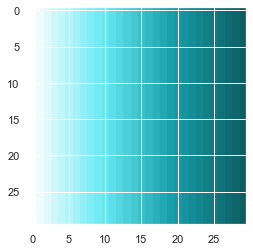

In [74]:
# Create custom colormap for use in heatmaps
colors = [(1, 1, 1), ((106/256, 235/256, 245/256)), ((22/256, 159/256, 169/256)), ((14/256, 95/256, 101/256))] # first color is black, last is red
cm = LinearSegmentedColormap.from_list(
        "Custom", colors, N=30)
mat = np.indices((30,30))[1]
plt.imshow(mat, cmap=cm)
plt.show()

In [16]:
sns.set(font_scale=2.0)

# FIGURE SAVING SETTINGS
#sns.set(font_scale=4.0)
#plt.rcParams['text.color'] = 'white'
#plt.rcParams['axes.labelcolor'] = 'white'
#plt.rcParams['xtick.color'] = 'white'
#plt.rcParams['ytick.color'] = 'white'


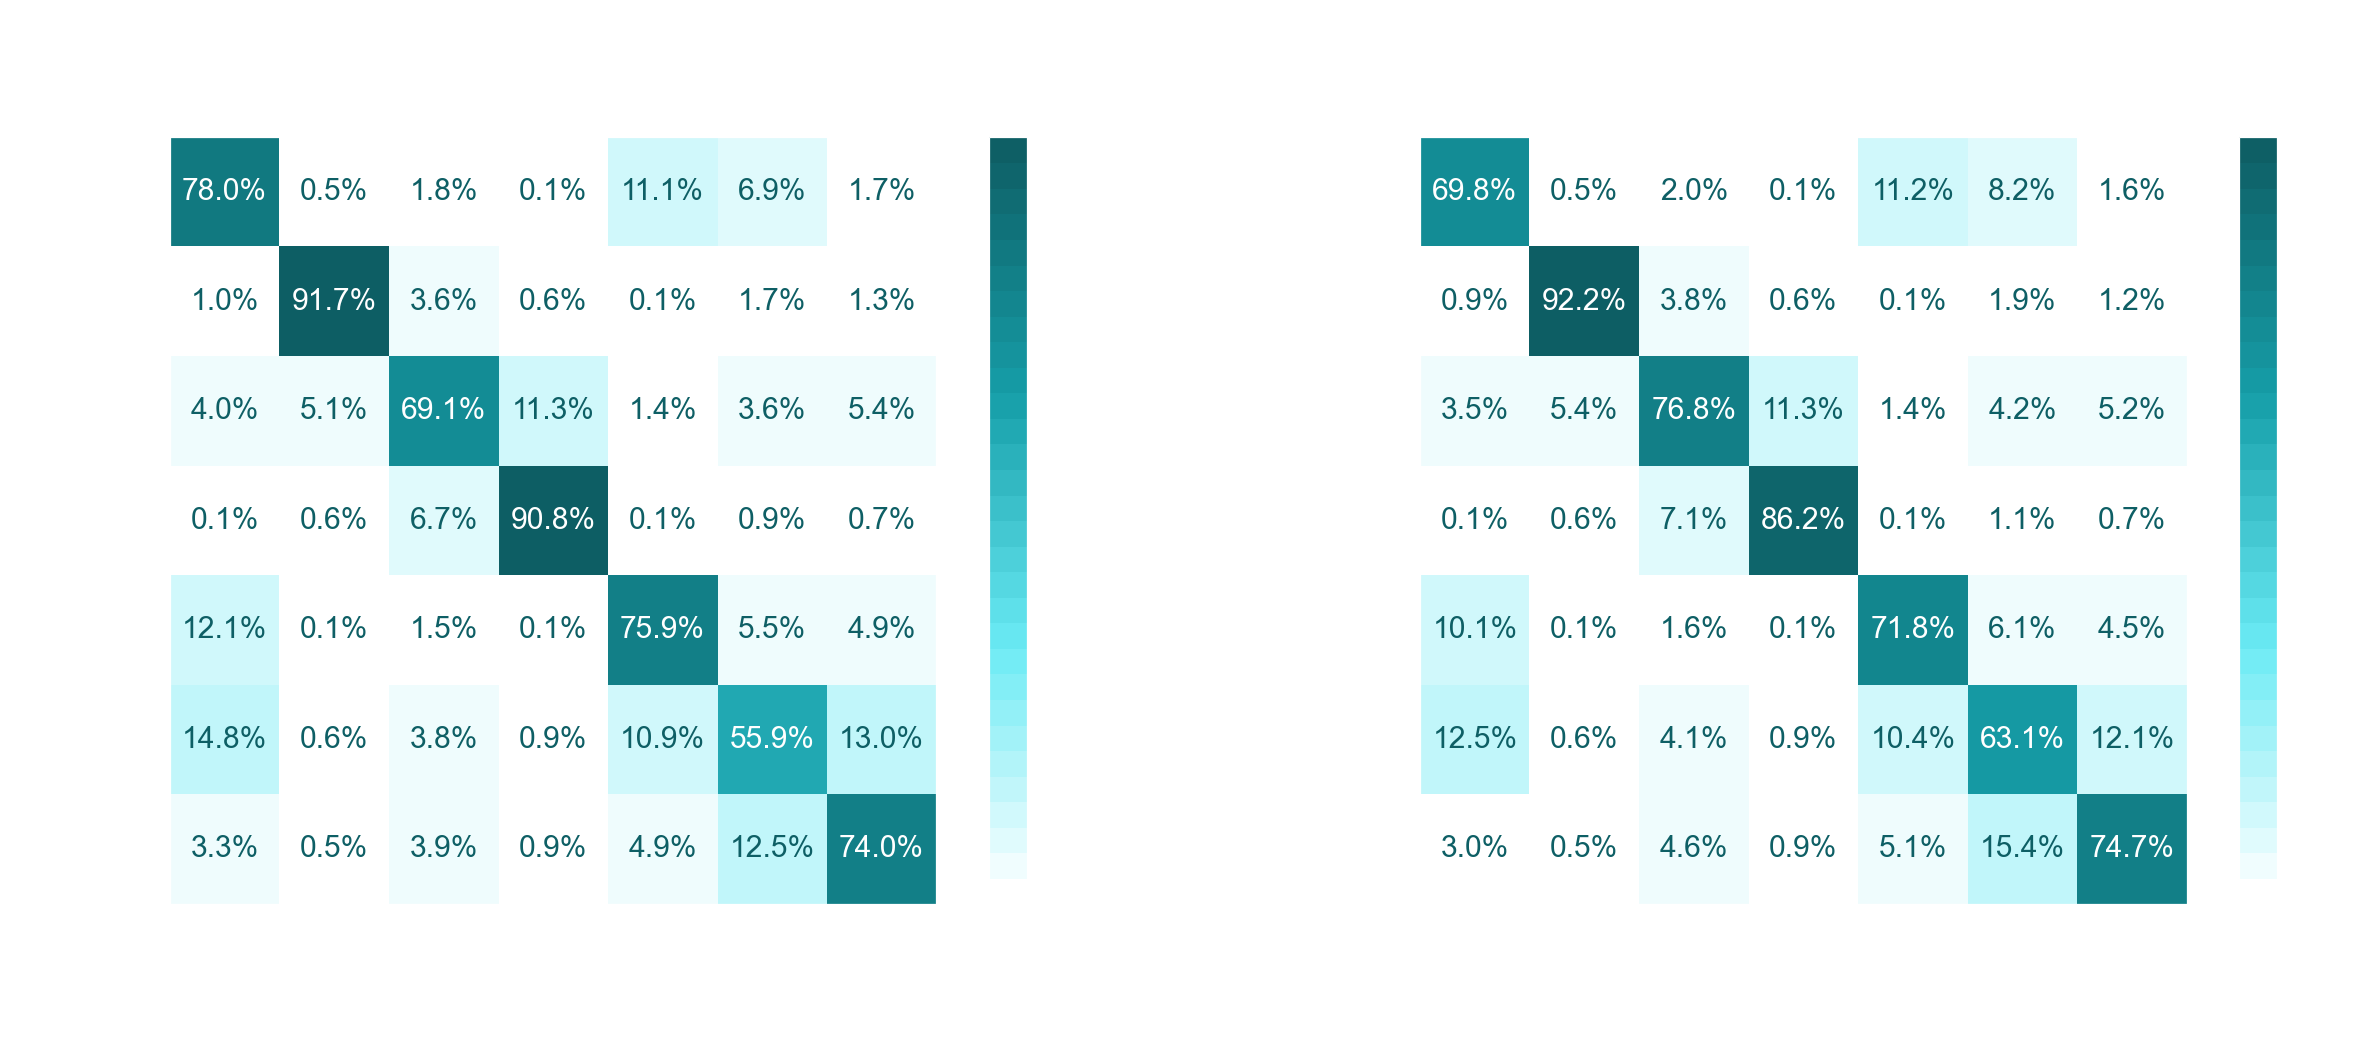

In [17]:
plt.rcParams.update({'font.size': 30})

confusion(classifier=rf_classifier, x_test=x_test, y_test=y_test, y_pred=y_pred,
          model='Random Forest', cmap=cm)

In [19]:
rf_feature_importance = pd.DataFrame({'Feature' : reduced_features + [dummy], 'Importance' : rf_classifier.feature_importances_})\
                            #.sort_values('Importance', ascending=False)

rf_feature_importance.sort_values('Importance', ascending=False)

,Feature,Importance
8,tempo,0.347159
2,danceability,0.100906
6,loudness,0.093429
0,duration_ms,0.091711
4,instrumentalness,0.073677
3,energy,0.067065
7,speechiness,0.060083
9,valence,0.059519
1,acousticness,0.053425
5,liveness,0.045003


# Model Evaluation Using Recommendations

In [7]:
# Train test split
X = model_data_recs[reduced_features + [dummy]]
Y = model_data_recs['genre']
            
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=13)

In [8]:
# Unaltered Random Forest Model
rf_classifier.fit(x_train, y_train)
y_pred = rf_classifier.predict(x_test)
y_pred_train = rf_classifier.predict(x_train)
score = accuracy_score(y_test, y_pred, normalize = True)
train_score = accuracy_score(y_train, y_pred_train, normalize = True)

In [9]:
print('Final Model Train Score: ' + '{:0.4f}'.format(train_score))
print('Final Model Test Score:  ' + '{:0.4f}'.format(score))

Final Model Train Score: 1.0000
Final Model Test Score:  0.8214


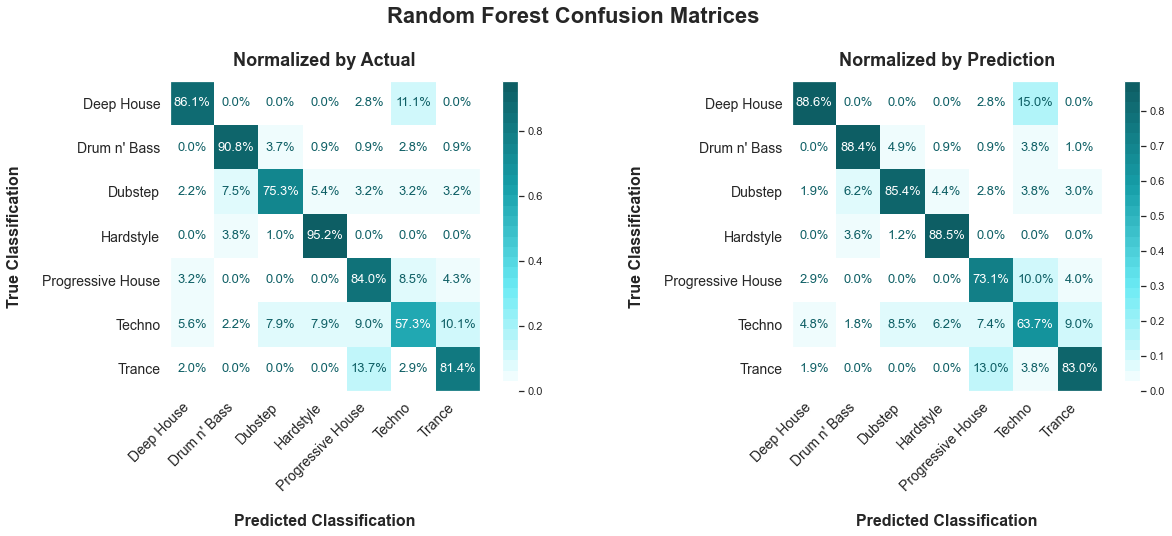

In [18]:
plt.rcParams.update({'font.size': 13})

confusion(classifier=rf_classifier, x_test=x_test, y_test=y_test, y_pred=y_pred,
          model='Random Forest', cmap=cm)

In [67]:
xgboost_features = ['duration_ms', 'acousticness', 'danceability', 'energy', 'instrumentalness', 
                    'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'valence', 'key_0', 
                    'key_1', 'key_2', 'key_4', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11', 
                    'time_sig_3', 'time_sig_4', 'time_sig_5']

In [68]:
# Train test split
X = model_data[xgboost_features]
Y = model_data['genre']
            
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=13)

In [69]:
# Unaltered Random Forest Model
xgb_classifier.fit(x_train, y_train)
y_pred = xgb_classifier.predict(x_test)
y_pred_train = xgb_classifier.predict(x_train)
score = accuracy_score(y_test, y_pred, normalize = True)
train_score = accuracy_score(y_train, y_pred_train, normalize = True)

In [70]:
print('Final Model Train Score: ' + '{:0.4f}'.format(train_score))
print('Final Model Test Score:  ' + '{:0.4f}'.format(score))

Final Model Train Score: 0.9957
Final Model Test Score:  0.7724


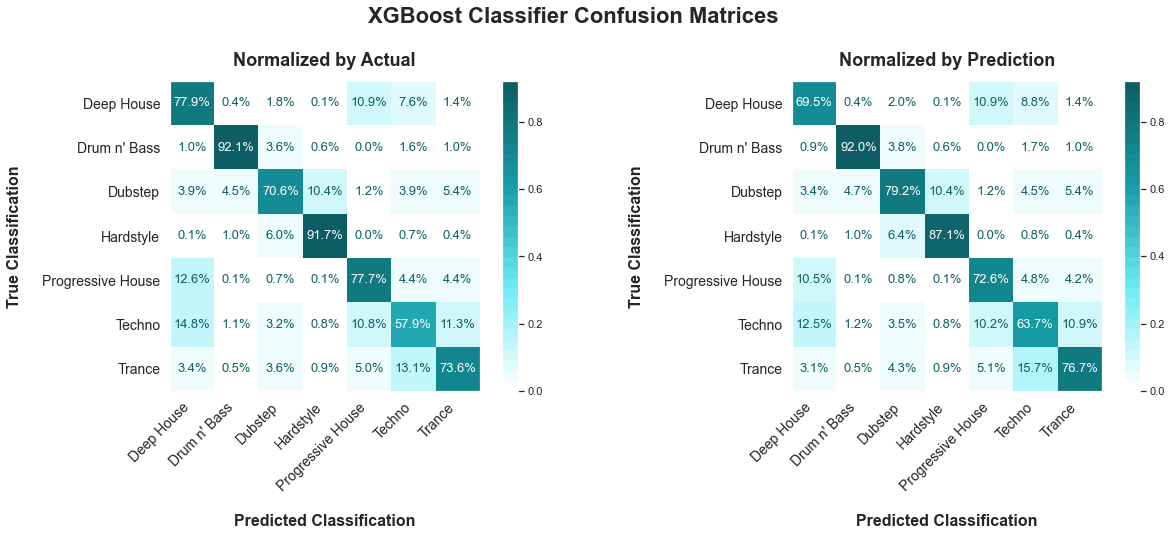

In [76]:
plt.rcParams.update({'font.size': 13})

confusion(classifier=xgb_classifier, x_test=x_test, y_test=y_test, y_pred=y_pred,
          model='XGBoost Classifier', cmap=cm)